In [22]:
import pandas as pd
import glob


path = '../data/raw/'

csv_files = glob.glob(path + "*.csv")

users = pd.read_csv(csv_files[0])
messages = pd.read_csv(csv_files[1])
internet = pd.read_csv(csv_files[2])
calls = pd.read_csv(csv_files[3])
plans = pd.read_csv(csv_files[4])

# Convertir fechas a tipo datetime
users["reg_date"] = pd.to_datetime(users["reg_date"])
users["churn_date"] = pd.to_datetime(users["churn_date"])

messages["message_date"] = pd.to_datetime(messages["message_date"])
internet["session_date"] = pd.to_datetime(internet["session_date"])
calls["call_date"] = pd.to_datetime(calls["call_date"])

In [23]:
plans['usd_per_mb'] = plans['usd_per_gb'] / 1024
print(plans[['plan_name', 'usd_per_gb', 'usd_per_mb']])

  plan_name  usd_per_gb  usd_per_mb
0      surf          10    0.009766
1  ultimate           7    0.006836


In [24]:
# Duplicados
df_duplicates = {
    'users': users.duplicated().sum(),
    'messages': messages.duplicated().sum(),
    'internet': internet.duplicated().sum(),
    'calls': calls.duplicated().sum(),
    'plans': plans.duplicated().sum()
}
print("\nCantidad de duplicados en cada dataset:")
print(df_duplicates)


Cantidad de duplicados en cada dataset:
{'users': np.int64(0), 'messages': np.int64(0), 'internet': np.int64(0), 'calls': np.int64(0), 'plans': np.int64(0)}


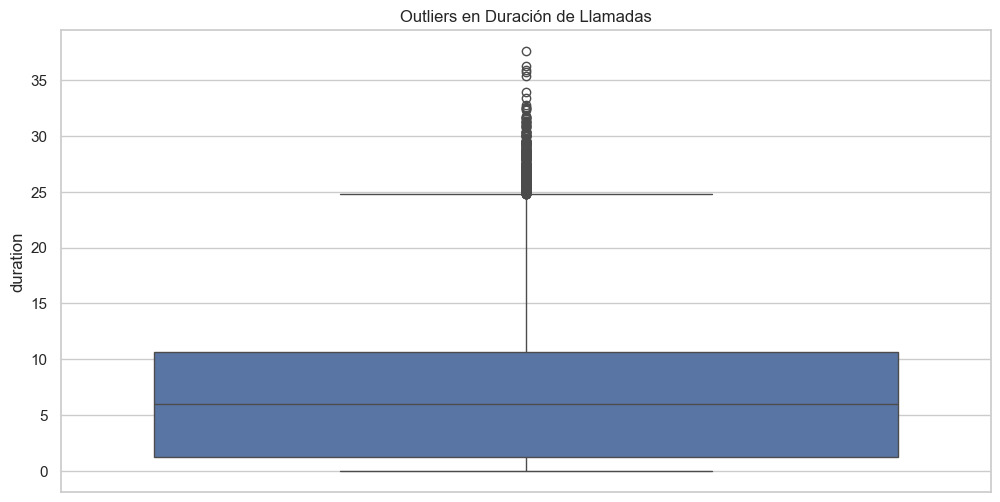

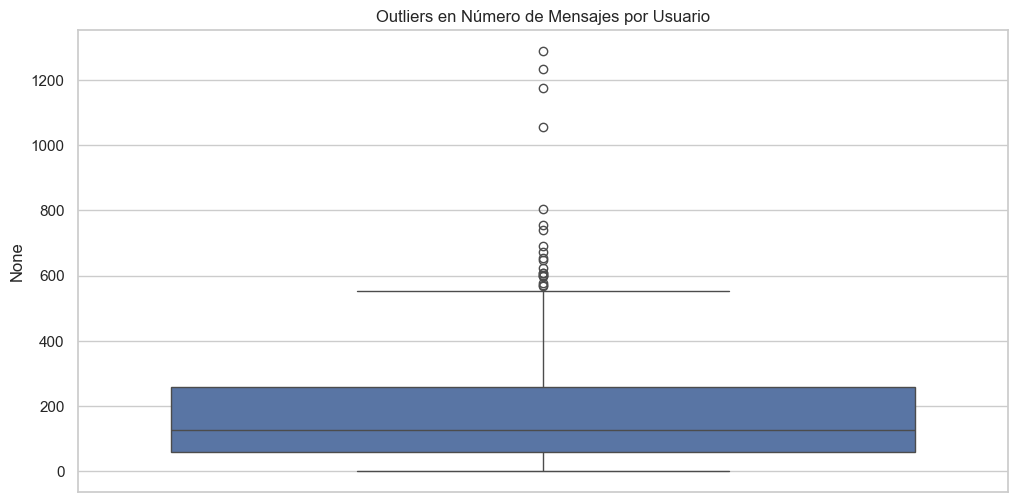

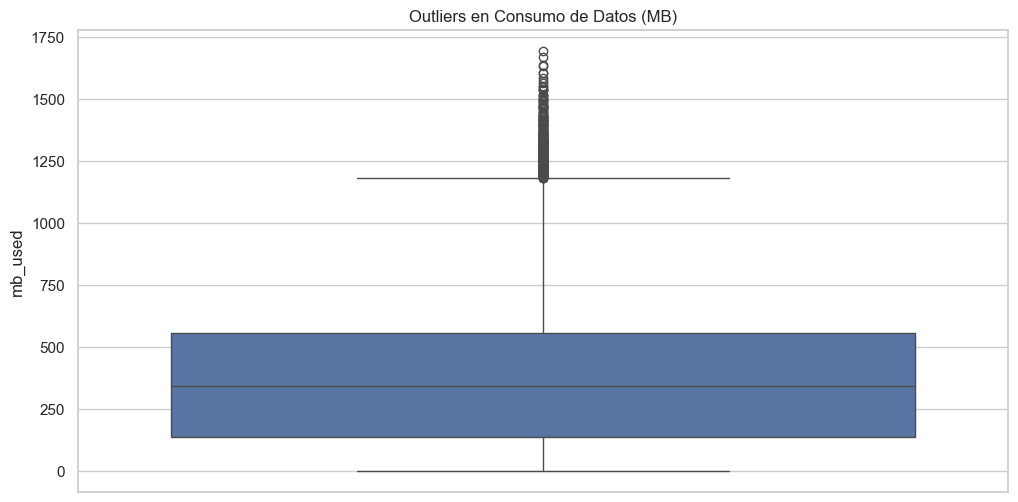

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Detección de outliers
plt.figure(figsize=(12,6))
sns.boxplot(y=calls['duration'])
plt.title("Outliers en Duración de Llamadas")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(y=messages.groupby('user_id').size())
plt.title("Outliers en Número de Mensajes por Usuario")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(y=internet['mb_used'])
plt.title("Outliers en Consumo de Datos (MB)")
plt.show()

In [27]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_calls_clean = remove_outliers(calls, 'duration')

df_messages_clean = remove_outliers(messages.groupby('user_id').size().reset_index(name='message_count'), 'message_count')

df_internet_clean = remove_outliers(internet, 'mb_used')

print("Datos de llamadas sin outliers:")
print(calls.describe())

print("\nDatos de mensajes sin outliers:")
print(messages.describe())

print("\nDatos de internet sin outliers:")
print(internet.describe())

Datos de llamadas sin outliers:
             user_id                      call_date       duration
count  137735.000000                         137735  137735.000000
mean     1247.658046  2018-09-25 19:57:56.319018496       6.745927
min      1000.000000            2018-01-15 00:00:00       0.000000
25%      1128.000000            2018-08-08 00:00:00       1.290000
50%      1247.000000            2018-10-12 00:00:00       5.980000
75%      1365.000000            2018-11-26 00:00:00      10.690000
max      1499.000000            2018-12-31 00:00:00      37.600000
std       139.416268                            NaN       5.839241

Datos de mensajes sin outliers:
            user_id                   message_date
count  76051.000000                          76051
mean    1245.972768  2018-10-03 23:51:32.172358144
min     1000.000000            2018-01-15 00:00:00
25%     1123.000000            2018-08-22 00:00:00
50%     1251.000000            2018-10-20 00:00:00
75%     1362.000000       

In [28]:

max_date = max(
    messages["message_date"].max(),
    internet["session_date"].max(),
    calls["call_date"].max()
)

user_months = []

for _, user in users.iterrows():
    start_date = user["reg_date"]
    end_date = user["churn_date"] if pd.notna(user["churn_date"]) else max_date
    months = pd.date_range(start=start_date, end=end_date, freq="M").to_period("M")
    for month in months:
        user_months.append({"user_id": user["user_id"], "month": month})

user_months_df = pd.DataFrame(user_months)

messages_monthly = (
    messages.groupby([messages["user_id"], messages["message_date"].dt.to_period("M")])
    .size()
    .reset_index(name="total_messages")
    .rename(columns={"message_date": "month"})  # ¡Clave!
)

internet_monthly = (
    internet.groupby([internet["user_id"], internet["session_date"].dt.to_period("M")])
    ["mb_used"].sum()
    .reset_index(name="total_mb")
    .rename(columns={"session_date": "month"})  # ¡Clave!
)

calls_monthly = (
    calls.groupby([calls["user_id"], calls["call_date"].dt.to_period("M")])
    ["duration"].sum()
    .reset_index(name="total_minutes")
    .rename(columns={"call_date": "month"})  # ¡Clave!
)

usage = (
    user_months_df
    .merge(messages_monthly, on=["user_id", "month"], how="left")
    .merge(internet_monthly, on=["user_id", "month"], how="left")
    .merge(calls_monthly, on=["user_id", "month"], how="left")
    .fillna({
        "total_messages": 0,
        "total_mb": 0,
        "total_minutes": 0
    })
)

users_plans = users.merge(
    plans,
    left_on="plan",
    right_on="plan_name",
    how="left"
).drop(columns="plan_name")

dataset = usage.merge(users_plans, on="user_id", how="left")

dataset["extra_messages"] = (dataset["total_messages"] - dataset["messages_included"]).clip(lower=0)
dataset["extra_mb"] = (dataset["total_mb"] - dataset["mb_per_month_included"]).clip(lower=0)
dataset["extra_minutes"] = (dataset["total_minutes"] - dataset["minutes_included"]).clip(lower=0)

dataset["costo_extra_mensajes"] = dataset["extra_messages"] * dataset["usd_per_message"]
dataset["costo_extra_datos"] = (dataset["extra_mb"] / 1024) * dataset["usd_per_gb"]
dataset["costo_extra_llamadas"] = dataset["extra_minutes"] * dataset["usd_per_minute"]

dataset["total_cost"] = (
    dataset["usd_monthly_pay"]
    + dataset["costo_extra_mensajes"]
    + dataset["costo_extra_datos"]
    + dataset["costo_extra_llamadas"]
)

# Dataset final
final_columns = [
    "user_id", "month", "age", "city", "plan",
    "total_messages", "total_mb", "total_minutes",
    "messages_included", "mb_per_month_included", "minutes_included",
    "usd_monthly_pay", "total_cost"
]

final_dataset = dataset[final_columns]

print("¡Dataset generado sin errores!")
print(final_dataset.head())

¡Dataset generado sin errores!
   user_id    month  age                                   city      plan  \
0     1000  2018-12   45  Atlanta-Sandy Springs-Roswell, GA MSA  ultimate   
1     1001  2018-08   28        Seattle-Tacoma-Bellevue, WA MSA      surf   
2     1001  2018-09   28        Seattle-Tacoma-Bellevue, WA MSA      surf   
3     1001  2018-10   28        Seattle-Tacoma-Bellevue, WA MSA      surf   
4     1001  2018-11   28        Seattle-Tacoma-Bellevue, WA MSA      surf   

   total_messages  total_mb  total_minutes  messages_included  \
0            11.0   1901.47         116.83               1000   
1            30.0   6919.15         171.14                 50   
2            44.0  13314.82         297.69                 50   
3            53.0  22330.49         374.11                 50   
4            36.0  18504.30         404.59                 50   

   mb_per_month_included  minutes_included  usd_monthly_pay  total_cost  
0                  30720              300

/var/folders/bw/_sg2t27140qgsjyxv1gr3nyc0000gn/T/ipykernel_32229/3110383880.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start=start_date, end=end_date, freq="M").to_period("M")


In [29]:
final_dataset.duplicated().sum()

np.int64(0)

In [30]:
final_dataset.to_csv('../data/clean/final_dataset.csv', index=False)